# Investigating the Impact of Basis Quality on Leverage-Based Sample Selection

## Abstract

In this work, we study how basis quality influences leverage-based sample selection by comparing three classes of representations on MNIST: raw pixel features, random ReLU features, and convolutional neural networks with identical architectures but different random initializations. For each basis, we compute leverage scores and evaluate their effectiveness by training only on the top-k leverage points and measuring training accuracy as a function of k.

## Features

We consider three types of feature representations for the MNIST dataset:
1. **Raw Pixel Features**: The original pixel values of the images.
2. **Random ReLU Features**: Features generated by applying random ReLU transformations to the raw pixel data.
3. **Convolutional Neural Network (CNN) Features**: Features extracted from a CNN with the same architecture but different random initializations.
    - CNN A1-A5: Randomly initialized weights. Trained to do classification.
    - CNN B1-B5: Randomly initialized weights. Trained to do regression.
    - CNN C1-C5: Randomly initialized weights. Not trained.

## Investigations

### Question 1: How do different basises affect leverage-based sample selection?
1. **Leverage Score Computation**: For each feature representation, we compute the leverage scores of the training samples.
2. **Sample Selection**: We select the top-k samples based on their leverage scores.
3. **Model Training**: We train a classifier using only the selected top-k samples.
4. **Evaluation**: We evaluate the training accuracy as a function of k, the number of selected samples.

### Question 2: Do neural network prioritize the same samples across different random initializations? (In other words, are the leverage scores correlated across different random initializations? Is the idea of leverage score robust to random initialization?)

1. **Varying Basis Quality**: We systematically vary the quality of the basis by using different random initializations for the CNNs.
2. **Correlation Analysis**: We analyze the correlation of leverage scores across different random initializations to assess the robustness of leverage-based sample selection. (Measure the swap distance/rank correlation between leverage score rankings. Are they similar to each other? To random shuffling?)
3. **Sample Overlap**: We measure the overlap in selected samples across different random initializations to understand if certain samples are consistently prioritized.

In [1]:
import torch
import numpy as np
from mnist_embeddings import MnistConvNet


# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features, device=X.device)
    return torch.relu(X @ W) / np.sqrt(features)


from torchvision.datasets import MNIST

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)

MNIST_TRAIN = MNIST(
    root="~/Desktop/AliasingOperatorExperiments/data", train=True, download=True
)
MNIST_TEST = MNIST(
    root="~/Desktop/AliasingOperatorExperiments/data", train=False, download=True
)

mnist_X = MNIST_TRAIN.data.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
mnist_y = MNIST_TRAIN.targets.to(DEVICE)
test_mnist_X = MNIST_TEST.data.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
test_mnist_y = MNIST_TEST.targets.to(DEVICE)

combined_mnist_X = torch.cat([mnist_X, test_mnist_X], dim=0)
combined_mnist_y = torch.cat([mnist_y, test_mnist_y], dim=0)


import numpy as np
import torch

BASIS_FUNCTIONS = 200


# Embed the testing set (not the training set)
def embed_dataset(X, model, device, basics_functions=BASIS_FUNCTIONS):
    # Embed the data using the convolutional layers of the network
    embeddings = torch.tensor(
        np.zeros(
            (
                X.shape[0],
                basics_functions,
            )
        )
    ).to(device)

    with torch.no_grad():
        for batch_start in range(0, X.shape[0], 256):
            batch_end = min(batch_start + 256, X.shape[0])
            batch = X[batch_start:batch_end].to(device)
            batch_embeddings = model.embed(batch)
            embeddings[batch_start:batch_end] = batch_embeddings
    return embeddings


def load_model_embed_data(path: str):
    state = torch.load(path, map_location=DEVICE)
    net = MnistConvNet()
    net.load_state_dict(state)
    net.to(DEVICE)
    net.eval()
    embeddings = embed_dataset(combined_mnist_X, net, DEVICE, BASIS_FUNCTIONS)
    return embeddings


# Embeddings
LABELS = combined_mnist_y
RAW = combined_mnist_X.reshape(-1, 28 * 28)
# RELU_FEATURES = relu_features(combined_mnist_X, features=RAW.shape[1])

using cuda


In [5]:
import torch.linalg

RAW_TRAIN = mnist_X.reshape(-1, 28 * 28).cpu().numpy()
RAW_TEST = test_mnist_X.reshape(-1, 28 * 28).cpu().numpy()

# Linear Regression on MNIST
ONEHOT_LABELS = torch.nn.functional.one_hot(mnist_y, num_classes=10).float().cpu().numpy()

print(RAW_TRAIN.shape, ONEHOT_LABELS.shape)
coefficients = np.linalg.lstsq(RAW_TRAIN, ONEHOT_LABELS, rcond=None)[0]

preds = RAW_TEST @ coefficients
accuracy = (preds.argmax(axis=1) == test_mnist_y.cpu().numpy()).mean()
print("Linear regression test accuracy on MNIST:", accuracy.item())

res = RAW_TRAIN @ coefficients - ONEHOT_LABELS
print("Least-squares error:", np.linalg.norm(res, ord="fro") ** 2)

preds = RAW_TRAIN @ coefficients
accuracy = (preds.argmax(axis=1) == mnist_y.cpu().numpy()).mean()
print("Linear regression training accuracy on MNIST:", accuracy.item())

(60000, 784) (60000, 10)
Linear regression test accuracy on MNIST: 0.8534
Least-squares error: 23460.184
Linear regression training accuracy on MNIST: 0.8519333333333333


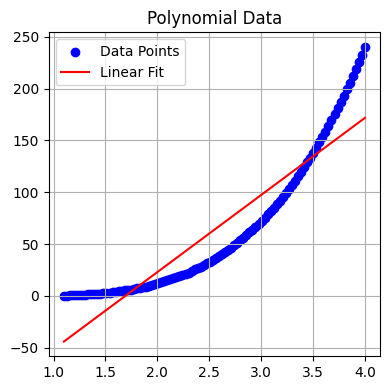

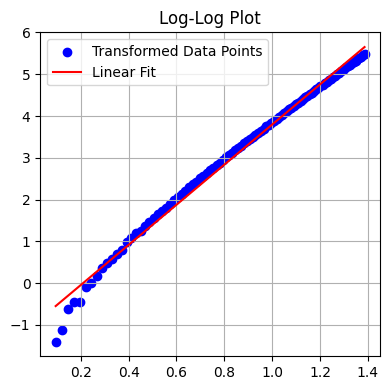

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(4, 4))
x_axis = np.linspace(1.1, 4, 100)
y = x_axis**4 - x_axis**2 + np.random.normal(0, 0.05, size=x_axis.shape)
plt.scatter(x_axis, y, color="blue", label="Data Points")
m,b = np.polyfit(x_axis, y, 1)
plt.plot(x_axis, m * x_axis + b, color="red", label="Linear Fit")
plt.title("Polynomial Data")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(4, 4))
ln_x_axis = np.log(x_axis)
ln_y = np.log(y)
m, b = np.polyfit(ln_x_axis, ln_y, 1)
plt.scatter(ln_x_axis, ln_y, color="blue", label="Transformed Data Points")
plt.plot(ln_x_axis, m * ln_x_axis + b, color="red", label="Linear Fit")
plt.title("Log-Log Plot")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [7]:
def calculate_leverage_scores(X: torch.Tensor) -> torch.Tensor:
    """Calculate the leverage scores for the given data matrix X.

    Args:
        X (torch.Tensor): Data matrix of shape (N, D).
    Returns:
        torch.Tensor: Leverage scores of shape (N,).
    """
    Q, _ = torch.linalg.qr(X, mode="reduced")
    leverage_scores = torch.sum(Q**2, dim=1)
    return leverage_scores

In [ ]:
# CNN_EMBEDDINGS = {}

# import glob

# for path in glob.glob("networks/mnist-cnn-*.pth"):
#     _, __, letter, hsh = path[:-4].split("-")
#     print("loading", letter, "from", path)
#     CNN_EMBEDDINGS[letter] = load_model_embed_data(path)

loading A2 from networks/mnist-cnn-A2-84ffa0eefcbeeb657268917dd8bee109056e2999075e32338726351bb75c7b0b.pth
loading A4 from networks/mnist-cnn-A4-b5afb85682d831c18f3cbb7fe5248165c77495ef8b708cb5c60e640db5cf706f.pth
loading B3 from networks/mnist-cnn-B3-7e4833a0cae78d546b36848bd5f70c3ea02b9620435c96ddfd683143d90094d9.pth
loading C3 from networks/mnist-cnn-C3-c4f4a4e0a690d76e8b806286779de48bfedd22e5a0193516818f7ac8a56e76cc.pth
loading C5 from networks/mnist-cnn-C5-76b75905dd222cf459fd87a887f4be4d4c98870117501e7af94b7ba539aba7af.pth
loading C1 from networks/mnist-cnn-C1-4b8f6cc4d9eb7a1c86025ba9042dd4a38ee373c03b9c4a9dc6d70d9a1f3f1422.pth
loading A5 from networks/mnist-cnn-A5-281c64ae0e093b5f25c74f563ab8df4816f691dac7192a6080025a1a5c5a5ea6.pth
loading C2 from networks/mnist-cnn-C2-588c7c77ff511977ba7fe7afa60390f279f894e7df3be09e88c462cb0598377f.pth
loading C4 from networks/mnist-cnn-C4-9009c2449e3cc1aa771cee71a6b91dbb638a932f29a760b9846599ba8fd3cd11.pth
loading A1 from networks/mnist-cnn-A1

# Question 1

In [15]:
# 1. Use the leverages scores of raw to order training subselection.
# Measure the accuracy every epoch on the test set, and plot the accuracy as a function of epoch for different training subselection methods.
# Plot multiple curves on the same plot, one for selecting the top-k leverage scores for different values of k.

from mnist_embeddings import MnistConvNet

import torch
from torch import optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)

## Randomly shuffle
indices = torch.randperm(mnist_X.shape[0])
train_ds = TensorDataset(
    mnist_X[indices],
    torch.nn.functional.one_hot(mnist_y[indices], num_classes=10),
)
test_ds = TensorDataset(test_mnist_X, test_mnist_y)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256)


def accuracy(net: MnistConvNet, device: torch.device) -> float:
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = net(xb)
            predicted = torch.argmax(preds, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    return correct / total


def train_classification(
    net: MnistConvNet, device: torch.device, epochs: int = 10, loader=train_loader
):
    criterion = torch.nn.CrossEntropyLoss()  # Changed from SmoothL1Loss
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # ---- Training loop ----
    for epoch in range(epochs):
        net.train()
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            preds = torch.nn.functional.softmax(net(xb), dim=1)
            loss = criterion(preds, yb.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        yield epoch, total_loss / len(loader), accuracy(net, device)


RAW_LEVERAGE_SCORES = calculate_leverage_scores(mnist_X.reshape(-1, 28 * 28))
SORTED_RAW_INDICES = torch.argsort(RAW_LEVERAGE_SCORES, descending=True)


state = torch.load(
    "networks/mnist-cnn-B1-84b328155fa96389e73cce5eed35404f17fa625a35db8b0beb7da142a279277f.pth",
    map_location=torch.device("cpu"),
)
net = MnistConvNet()
net.load_state_dict(state)
net.eval()
embedding = embed_dataset(mnist_X, net, torch.device("cpu"), basics_functions=200)
NN_LEVERAGE_SCORES = calculate_leverage_scores(embedding)
NN_SORTED_INDICES = torch.argsort(NN_LEVERAGE_SCORES, descending=True)

leverage_accs = {}
nn_leverage_accs = {}
regular_accs = {}
epochs = 15

for k in [1000, 5000, 10000, 20000, 50000]:
    net = MnistConvNet().to(DEVICE)
    leverage_net = MnistConvNet().to(DEVICE)
    nn_leverage_net = MnistConvNet().to(DEVICE)

    # ------------------------------------
    leverage_score_loader = DataLoader(
        TensorDataset(mnist_X[SORTED_RAW_INDICES[:k]], torch.nn.functional.one_hot(mnist_y[SORTED_RAW_INDICES[:k]], num_classes=10)),
        batch_size=64,
        shuffle=False,
    )
    accs = []
    print(f"Training with {k} samples by leverage scores:")
    for epoch, loss, acc in train_classification(
        leverage_net, DEVICE, epochs=epochs, loader=leverage_score_loader
    ):
        print(
            f"    Epoch {epoch+1}: train_loss = {loss:.4f}, test_accuracy = {acc:.4f}"
        )
        accs.append(acc)
    leverage_accs[k] = accs

    # ------------------------------------
    indices = torch.randperm(mnist_X.shape[0])[:k]
    random_loader = DataLoader(
        TensorDataset(
            mnist_X[indices],
            torch.nn.functional.one_hot(mnist_y[indices], num_classes=10),
        ),
        batch_size=64,
        shuffle=False,
    )

    accs = []
    print(f"Training with random {k} samples:")
    for epoch, loss, acc in train_classification(
        net, DEVICE, epochs=epochs, loader=random_loader
    ):
        print(
            f"    Epoch {epoch+1}: train_loss = {loss:.4f}, test_accuracy = {acc:.4f}"
        )
        accs.append(acc)
    regular_accs[k] = accs

    # ------------------------------------
    nn_leverage_score_loader = DataLoader(
        TensorDataset(mnist_X[NN_SORTED_INDICES[:k]], torch.nn.functional.one_hot(mnist_y[NN_SORTED_INDICES[:k]], num_classes=10)),
        batch_size=64,
        shuffle=False,
    )

    accs = []
    print(f"Training with {k} samples by NN leverage scores:")
    for epoch, loss, acc in train_classification(
        nn_leverage_net, DEVICE, epochs=epochs, loader=nn_leverage_score_loader
    ):
        print(
            f"    Epoch {epoch+1}: train_loss = {loss:.4f}, test_accuracy = {acc:.4f}"
        )
        accs.append(acc)
    nn_leverage_accs[k] = accs

Training with 1000 samples by leverage scores:
    Epoch 1: train_loss = 2.0975, test_accuracy = 0.1964
    Epoch 2: train_loss = 2.0340, test_accuracy = 0.1932
    Epoch 3: train_loss = 2.0333, test_accuracy = 0.1972
    Epoch 4: train_loss = 2.0318, test_accuracy = 0.1966
    Epoch 5: train_loss = 2.0299, test_accuracy = 0.1968
    Epoch 6: train_loss = 2.0279, test_accuracy = 0.1974
    Epoch 7: train_loss = 1.9733, test_accuracy = 0.2888
    Epoch 8: train_loss = 1.8471, test_accuracy = 0.3493
    Epoch 9: train_loss = 1.7632, test_accuracy = 0.4397
    Epoch 10: train_loss = 1.7311, test_accuracy = 0.4700
    Epoch 11: train_loss = 1.7187, test_accuracy = 0.4821
    Epoch 12: train_loss = 1.7088, test_accuracy = 0.4781
    Epoch 13: train_loss = 1.7000, test_accuracy = 0.5274
    Epoch 14: train_loss = 1.6729, test_accuracy = 0.5318
    Epoch 15: train_loss = 1.6634, test_accuracy = 0.5306
Training with random 1000 samples:
    Epoch 1: train_loss = 2.1054, test_accuracy = 0.6131


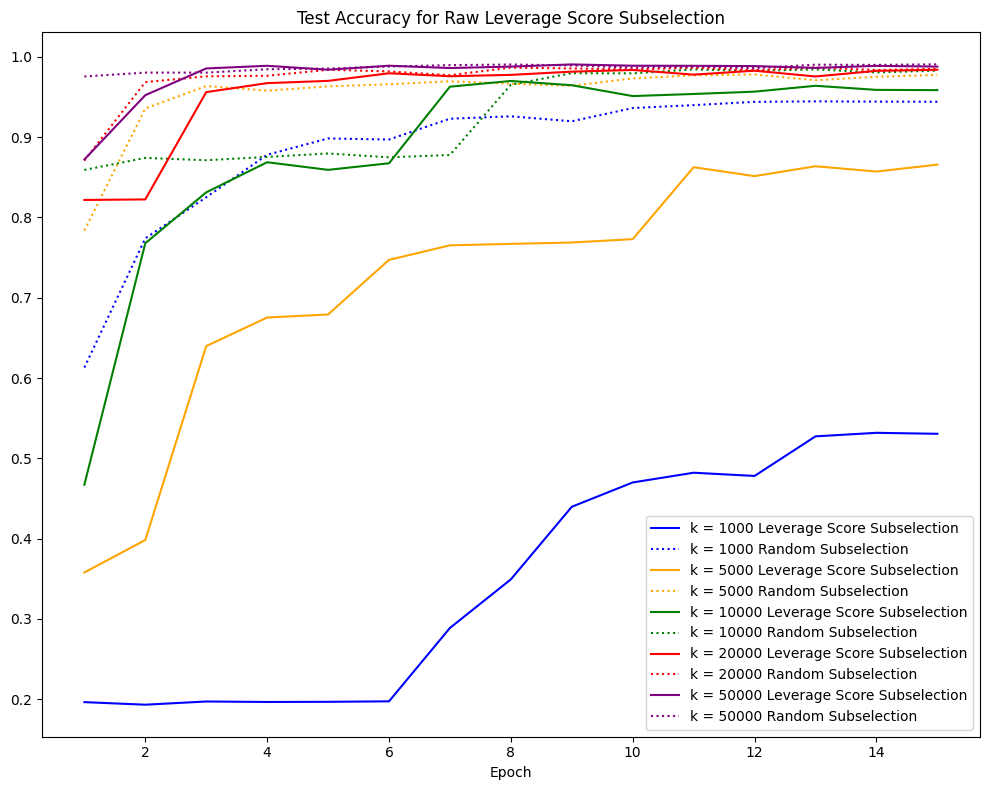

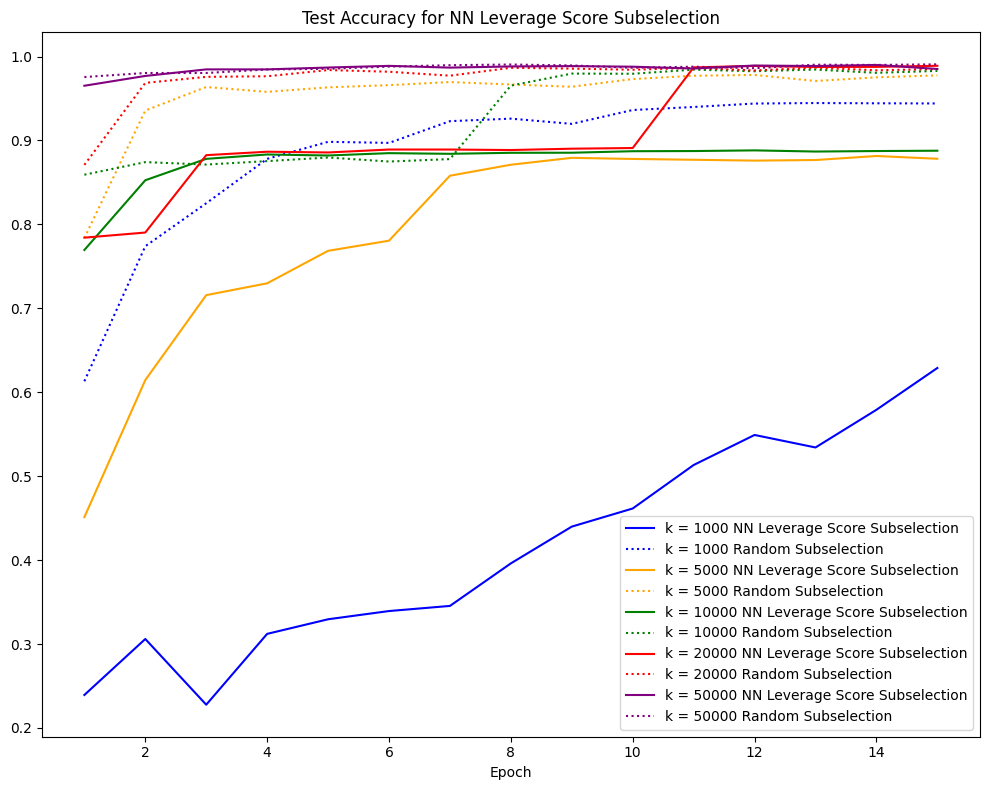

In [21]:
from matplotlib import pyplot as plt
import json

with open("figures/neural_networks_with_leverage_scores.json", "w") as f:
    json.dump(
        {
            "leverage_accs": leverage_accs,
            "regular_accs": regular_accs,
            "nn_leverage_accs": nn_leverage_accs,
        },
        f,
    )
colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray"]
plt.figure(figsize=(10, 8))
for i, k in enumerate(leverage_accs.keys()):
    plt.plot(
        range(1, epochs + 1),
        leverage_accs[k],
        label=f"k = {k} Leverage Score Subselection",
        color=colors[i % len(colors)],
    )
    plt.plot(
        range(1, epochs + 1),
        regular_accs[k],
        label=f"k = {k} Random Subselection",
        linestyle="dotted",
        color=colors[i % len(colors)],
    )
plt.xlabel("Epoch")
plt.legend()
plt.title("Test Accuracy for Raw Leverage Score Subselection")
plt.tight_layout()
plt.savefig("figures/neural_networks_with_leverage_scores.png")
plt.show()

plt.figure(figsize=(10, 8))
for i, k in enumerate(leverage_accs.keys()):
    plt.plot(
        range(1, epochs + 1),
        nn_leverage_accs[k],
        label=f"k = {k} NN Leverage Score Subselection",
        color=colors[i % len(colors)],
    )
    plt.plot(
        range(1, epochs + 1),
        regular_accs[k],
        label=f"k = {k} Random Subselection",
        linestyle="dotted",
        color=colors[i % len(colors)],
    )
plt.xlabel("Epoch")
plt.legend()
plt.title("Test Accuracy for NN Leverage Score Subselection")
plt.tight_layout()
plt.savefig("figures/neural_networks_with_nn_leverage_scores.png")
plt.show()

# Question 2

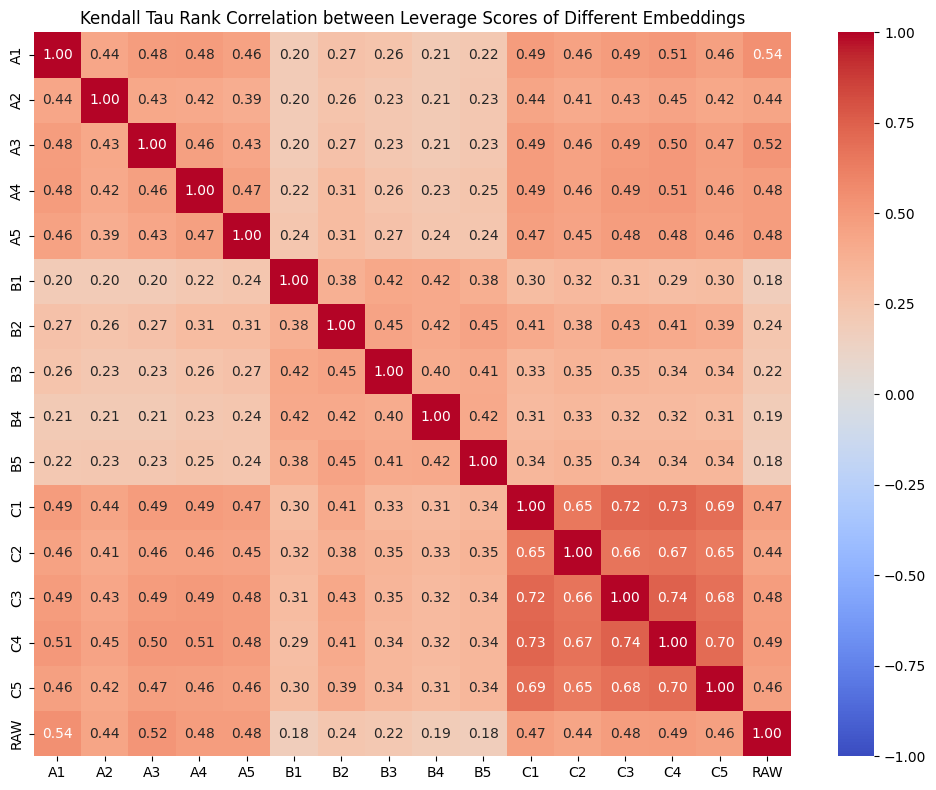

In [12]:
from pathlib import Path

# Measure the Kendall tau rank correlation between leverage scores rankings of different embeddings
from scipy.stats import kendalltau

EMBEDDINGS = ["RAW"] + list(CNN_EMBEDDINGS.keys())
LEVERAGE_SCORES = {}
for name, embedding in zip(
    EMBEDDINGS, [RAW] + list(CNN_EMBEDDINGS.values())
):
    leverage_scores = calculate_leverage_scores(embedding).cpu().numpy()
    LEVERAGE_SCORES[name] = leverage_scores

WEIGHTED_RANK_CORRELATIONS = {}  # (name, other_name): (tau, p_value)

for i, (name, scores) in enumerate(LEVERAGE_SCORES.items()):
    for j, (other_name, other_scores) in enumerate(LEVERAGE_SCORES.items()):
        if i <= j:
            tau, _ = kendalltau(scores, other_scores)
            WEIGHTED_RANK_CORRELATIONS[",".join(tuple(sorted([name, other_name])))] = (
                tau
            )

import json

with open(Path("figures/rank_correlations.json"), "w") as f:
    json.dump(WEIGHTED_RANK_CORRELATIONS, f, indent=4)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Pairplot the rank correlations tau values
correlation_matrix = pd.DataFrame(
    index=sorted(EMBEDDINGS), columns=sorted(EMBEDDINGS), dtype=float
)
for name_pair, tau in WEIGHTED_RANK_CORRELATIONS.items():
    name1, name2 = name_pair.split(",")
    correlation_matrix.loc[name1, name2] = tau
    correlation_matrix.loc[name2, name1] = tau
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix.astype(float),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
plt.title(
    "Kendall Tau Rank Correlation between Leverage Scores of Different Embeddings"
)
plt.tight_layout()
plt.savefig(Path("figures/rank_correlation_heatmap.png"))
plt.show()